# Portfolio Optimization Using Signals

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

We are interested in combining multiple stocks into a single investment portfolio. This can be done naively by having equal weights for all the stocks, or we can try and do it more intelligently so as to maximize some performance measure, which is called portfolio optimization.

Academia teaches only one method of portfolio optimization in investment finance: Markowitz Portfolio Theory, also known as Mean-Variance portfolio optimization because it seeks to maximize the portfolio's mean return while minimizing its variance. However, there are several problems with this method:

Firstly, the method assumes that historical returns and their covariances will continue in the future and does not use any predictive signals to adjust the future return distributions.

Secondly and perhaps more importantly, the method uses the variance (or equivalently the standard deviation) of the return distribution as a risk measure that must be minimized. But this is a fundamental misunderstanding of both finance, statistics and even the English language, because the variance measures the **spread** of a distribution, while the word "risk" of course means "the chance of injury or loss" which is not measured by the variance.

I have previously made YouTube videos explaining this problem [here](https://www.youtube.com/watch?v=wr8NzThfpAE) and [here](https://www.youtube.com/watch?v=0temN7hAf2c). The following cartoon is a funny but very accurate criticism of this fatal flaw of Markowitz portfolio theory:

![Dilbert Cartoon](images/dilbert.gif)

In the [first paper of this series](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb), we showed that the P/Sales ratio could be used as a predictor for long-term returns of the S&P 500 and some individual stocks. In this paper we will develop a method for allocating portfolios using such predictive signals. Although we cannot test the method properly because of a lack of financial data, we do show that the stock-weights are allocated as we would expect from the predictive signals, which indicates that the method could work quite well if we had more financial data. The method should also work with signals predicting short and mid-term returns.

## Flowchart

The overall idea is to create a portfolio model which is basically just a mathematical function that maps the predictive signals to stock-weights. The portfolio model has a number of parameters that are found using a heuristic optimizer so as to result in good investment performance.

The flowchart shows roughly how the optimizer produces new model parameters, which are then used by the portfolio model to map the predictive signals to stock-weights, which are then multiplied with the stock returns to produce the cumulative value of the portfolio. We can then calculate various performance measures from this and feed the result back into the optimizer to produce a new set of model parameters to try. This loop is repeated until satisfactory model parameters are found.

![Flowchart](images/03_flowchart_portfolio_optimization.png)

## Portfolio Models

We will use three different portfolio models:

- Equal-weights portfolio which does not require any optimization because its stock-weights are all equal, so the portfolio is merely rebalanced with equal weights every day.
- Fixed-weights portfolio which uses fixed but possibly non-equal stock-weights for the daily rebalancing. The best stock-weights are found through optimization as shown in the flowchart.
- Adaptive-weights portfolio which adapts the stock-weights using the predictive signals. The mapping is a mathematical function whose parameters are found through optimization as shown in the flowchart.

## Direct vs. Indirect Portfolio Allocation

We might consider this method to be a form of "direct" portfolio allocation because we are mapping directly from the predictive signals to the stock-weights.

An "indirect" method of portfolio allocation would first have to estimate the return distributions for the stocks and then use those distributions to find an optimal portfolio allocation.

The advantage of our "direct" method, is that it avoids the complexity of having to model the return distributions, which would probably also have significant estimation errors. It also avoids a complicated optimization problem, which would have to be solved every time the portfolio should be rebalanced.

Instead our "direct" way of doing portfolio allocation simply maps the predictive signals to stock-weights in a manner that has been found to work well on the training-data.

## Fitness Measure

The fitness function measures how well the portfolio model performs on the training-set. This is used to guide the optimization procedure to find better parameters for the portfolio model.

There are many ways of defining the fitness function. It is implemented in the function `portfolio.Model._fitness()` which gives an example. The main fitness measure is the mean-log return for all 5-year investment periods, which is also known as the Kelly Criterion. The main fitness is then severely penalized if more than 7% of all 1-year investment periods had losses. This means we strongly prefer portfolio models with few 1-year losses, possibly at the cost of lower long-term returns.

There are infinitely many ways of defining the fitness function. This can be used to shape the return distribution in different ways. Because we use a heuristic optimizer we do not need a gradient for the fitness function, so it is very easy to implement and experiment with.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [ ]:
%matplotlib inline

In [ ]:
# Imports from Python packages.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Imports from FinanceOps.
from data_keys import *
from data import load_stock_data, load_index_data
from portfolio import EqualWeights, FixedWeights, AdaptiveWeights
from returns import daily_returns

## Load Data

We now define and load all the financial data we will be using.

In [ ]:
# Ticker-names for the stock indices.
ticker_SP500 = "S&P 500"
ticker_SP400 = "S&P 400"
ticker_SP600 = "S&P 600"
tickers_indices = [ticker_SP500, ticker_SP400, ticker_SP600]

Data is also included for the stocks GPC and WMT but doing the analysis in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) on those two stocks shows that their P/Sales ratios are not a good predictor for their returns, so those two stocks are omitted here.

In [ ]:
# Ticker-names for the stocks.
tickers_stocks = ['CLX', 'CPB', 'DE', 'DIS', 'GIS',
                  'HSY', 'JNJ', 'K', 'PG']

In [ ]:
# List of all tickers for the indices and stocks.
tickers = tickers_indices + tickers_stocks

In [ ]:
# Load the financial data for the stock indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400,
                           sales=False, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600,
                           sales=False, book_value=False)

# DataFrames for all stock indices.
dfs_indices = [df_SP500, df_SP400, df_SP600]

In [ ]:
# Load financial data for all stocks to a list of DataFrames.
dfs_stocks = [load_stock_data(ticker=ticker)
              for ticker in tickers_stocks]

In [ ]:
# List of all DataFrames for the indices and stocks.
dfs = dfs_indices + dfs_stocks

In [ ]:
# Total number of stocks and indices.
num_stocks = len(dfs)
num_stocks

12

## Predictive Signals

We saw in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) that the P/Sales ratio was a strong predictor for the long-term returns of the S&P 500 and some individual stocks, so we will be using the P/Sales ratio as the predictive signal for those stocks.

For the S&P 400 and S&P 600 indices we do not have the P/Sales data but we do have the Dividend Yield, which is also a good predictor for the long-term returns of those indices. You should confirm this by doing the analysis in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) for those two indices.

It is extremely important that you analyse the relationship between a given signal and the stock returns before you use that signal, because the optimizer will try and uncover a relationship whether there really is one or not. It may work very well on the training-set, but it may not generalize to the future.

You should therefore always do analysis like the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) before you use a predictive signal!

Similarly, you should be careful that your mathematical model only maps signals to stock-weights where the signal has a causal relationship with that particular stock. For example, a fully-connected neural network would allow all signals to be used to determine the weights for all the stocks, but the P/Sales for one company clearly has nothing to do with the future return of another company's stock - except for perhaps a historical coincidence in the training-set, which is unlikely to occur again in the future.

Note that we make a simple implementation here which only allows one signal per stock.

In [ ]:
# Predictive signals for the stock indices.
signals_indices = [df_SP500[PSALES],
                   df_SP400[DIVIDEND_YIELD],
                   df_SP600[DIVIDEND_YIELD]]

In [ ]:
# Predictive signals for the stocks.
signals_stocks = [df[PSALES] for df in dfs_stocks]

In [ ]:
# Combine all the signals into a single list.
signals = signals_indices + signals_stocks

In [ ]:
# Create a Pandas DataFrame.
df_signals = pd.concat(signals, axis=1)

In [ ]:
# Remove rows with missing data.
df_signals.dropna(inplace=True)

In [ ]:
# Show the top rows of the valid signals.
df_signals.head()

,P/Sales,Dividend Yield,Dividend Yield,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales
Date,,,,,,,,,,,,
1994-09-30,0.904257,0.020246,0.011155,1.491139,1.508969,0.659435,2.064559,1.036528,1.094454,2.405291,1.998021,1.313643
1994-10-01,0.903559,0.020276,0.011180,1.486003,1.511047,0.660563,2.083179,1.035625,1.096352,2.398748,1.999083,1.311459
1994-10-02,0.902861,0.020305,0.011205,1.480870,1.513128,0.661691,2.101774,1.034720,1.098250,2.392209,2.000145,1.309276
1994-10-03,0.902164,0.020335,0.011230,1.475739,1.515209,0.662819,2.120346,1.033812,1.100147,2.385674,2.001207,1.307094
1994-10-04,0.888129,0.020631,0.011419,1.471802,1.472666,0.642335,2.072468,1.030647,1.090902,2.326918,1.983420,1.298494


In [ ]:
# Period for which we have valid signals.
start_date, end_date = df_signals.index[[0, -1]]

In [ ]:
# The raw unscaled signals.
signals_raw = df_signals.values

In [ ]:
# The signals could have widely different ranges,
# so we scale the signals to be between 0.0 and 1.0
signals_scaler = MinMaxScaler()
signals_scaled = signals_scaler.fit_transform(signals_raw)

## Daily Returns

We need the daily returns for all the stocks because we will rebalance the portfolio every day according to the stock-weights produced by our portfolio model.

We use interpolated data so we have the stock-prices and their daily returns for all days including weekends and holidays. This makes the programming easier for this demonstration, but a real implementation should probably only use real data points to avoid distortions.

In [ ]:
# Add a day to the period because we most likely have the
# Total Return data for that day as well, and that means
# we calculate the daily return for the end_date as well.
end_date_plus1 = end_date + pd.DateOffset(days=1)

In [ ]:
# Calculate daily returns using the Total Return for all stocks.
daily_rets = np.array([daily_returns(df, start_date, end_date_plus1)
                       for df in dfs])

In [ ]:
# Transpose the 2-dim array.
daily_rets = daily_rets.T
daily_rets.shape

(8311, 12)

In [ ]:
# Remove the last row which only contains NAN.
daily_rets = daily_rets[0:-1, :]
daily_rets.shape

(8310, 12)

## Weight Bounds

We only allow for so-called "long" investing without margin, which means that the stock-weights are bounded between 0.0 and 1.0, and their sum must be less or equal to 1.0.

In [ ]:
min_weights = np.zeros(num_stocks, dtype=np.float)
max_weights = np.ones(num_stocks, dtype=np.float)

<ipython-input-36-857d03542105>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_weights = np.zeros(num_stocks, dtype=np.float)
<ipython-input-36-857d03542105>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_weights = np.ones(num_stocks, dtype=np.float)


Furthermore, we limit the weights for the individual stocks to 0.2 (or 20%) of the portfolio, while allowing the stock-indices to have weights up to 1.0 (or 100%) of the portfolio. This is an attempt to regularize the portfolio model so it does not overfit to the training-set. Ideally we would have many more stocks to choose from so the stock-weights could be limited to e.g. 5% of the portfolio, but when we only have a small number of stocks, that would essentially mean that the portfolio would mostly be allocted to the indices and hence track those closely.

In [ ]:
max_weights[len(dfs_indices):] = 0.2

## Split Training- and Test-Sets

We now split the data-set evenly into a training-set and a test-set.

In [ ]:
# Total number of data-points.
num_data = len(daily_rets)

# Number of data-points in the training-set.
num_train = int(num_data * 0.5)

In [ ]:
# Indices for the training-set.
# These are used to lookup dates, daily returns, signals, etc.
idx_train = range(0, num_train)

# Indices for the test-set.
idx_test = range(num_train, num_data)

In [ ]:
# All dates for the entire period.
dates = df_SP500[start_date:end_date].index

# Dates for the training-set.
dates_train = dates[0:num_train]

# Dates for the test-set.
dates_test = dates[num_train:]

In [ ]:
# Daily returns for the training-set.
daily_rets_train = daily_rets[0:num_train]

# Daily returns for the test-set.
daily_rets_test = daily_rets[num_train:]

In [ ]:
# Signals for the training-set.
signals_train = signals_scaled[0:num_train]

# Signals for the test-set.
signals_test = signals_scaled[num_train:]

## Portfolio with Equal Weights

The most basic portfolio model uses equal weights for all the stocks and indices. It serves as a baseline for comparison to more advanced portfolio models.

In [ ]:
# Create portfolio model for equal weights.
portfolio_equal = EqualWeights(num_stocks=num_stocks, use_cash=False)

In [ ]:
# Get the weights.
weights_equal, weights_cash_equal = portfolio_equal.get_weights(signals_test)

In [ ]:
weights_equal

array([[0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
        0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
        0.08333333, 0.08333333]])

In [ ]:
weights_cash_equal

0.0

## Portfolio with Fixed Weights

Another baseline for use in comparison, is a portfolio model where the stock-weights are held fixed for all days, but the stock-weights need not be equal as they are found through optimization.

In [ ]:
%%time
# Create portfolio model for fixed weights and
# find the weights that perform best on the training-set.
portfolio_fixed = FixedWeights(signals_train=signals_train,
                               daily_rets_train=daily_rets_train,
                               min_weights=min_weights,
                               max_weights=max_weights)

CPU times: user 251 ms, sys: 3.51 ms, total: 255 ms
Wall time: 262 ms


In [ ]:
# Get the weights.
weights_fixed, weights_cash_fixed = portfolio_fixed.get_weights(signals_test)

In [ ]:
# Print the stock-weights. The remaining cash-weight is not shown.
for ticker, weight in zip(tickers, weights_fixed[0]):
    print("{0:7} {1:7.2%}".format(ticker, weight))
print("Sum  =  {0:7.2%}".format(np.sum(weights_fixed)))

S&P 500   0.00%
S&P 400  25.79%
S&P 600   0.00%
CLX       6.63%
CPB       0.00%
DE        3.74%
DIS       0.33%
GIS      20.00%
HSY       8.94%
JNJ      17.07%
K         7.65%
PG        9.86%
Sum  =  100.00%


## Portfolio with Adaptive Weights

The portfolio model with adaptive weights uses the signals for the stocks to determine the stock-weights in the portfolio. We use a simple linear function wrapped in a sigmoid-function to softly limit the result between 0.0 and 1.0. For example, the weight for the CLX stock is:

$$
    Weight_{CLX} = Sigmoid( a_{CLX} \cdot Signal_{CLX} + b_{CLX} )
$$

During optimization we are trying to find the parameters $a_{CLX}$ and $b_{CLX}$ that maximize the investment performance according to our fitness-function. We are trying to find the parameters for all stocks in the portfolio simultaneously.

There is some additional scaling on the weights to limit them between the valid boundaries, as well as ensuring that the weights for the entire portfolio are less or equal to 1.

In [ ]:
%%time
# Create portfolio model for adaptive weights and find the
# model-parameters that perform best on the training-set.
portfolio_adapt = AdaptiveWeights(signals_train=signals_train,
                                  daily_rets_train=daily_rets_train,
                                  min_weights=min_weights,
                                  max_weights=max_weights)

CPU times: user 1min 5s, sys: 109 ms, total: 1min 5s
Wall time: 1min 6s


### Print Adaptive Weight Formulas

We can print the linear formulas for the stock-weights that we have found in the optimization above. We ignore the sigmoid and other scalings here and show more detailed plots of the stock-weights further below.

In [ ]:
for ticker, a, b in zip(tickers,
                        portfolio_adapt._a,
                        portfolio_adapt._b):
    msg = "{0:8} weight = {1:6.2f} x signal + {2:6.2f}"
    print(msg.format(ticker, a, b))

S&P 500  weight =  -7.40 x signal +  -7.92
S&P 400  weight =  10.00 x signal +  -1.64
S&P 600  weight =  -1.32 x signal +  -9.81
CLX      weight = -10.00 x signal +   4.04
CPB      weight =  -2.62 x signal +  -6.09
DE       weight = -10.00 x signal +   2.42
DIS      weight =  -6.74 x signal +  -6.21
GIS      weight = -10.00 x signal +   5.70
HSY      weight = -10.00 x signal +   3.03
JNJ      weight = -10.00 x signal +   6.33
K        weight = -10.00 x signal +   2.69
PG       weight = -10.00 x signal +   4.94


## Plot Adaptive Weights

In [ ]:
def plot_weights_signals(idx):
    """
    Plot stock-weights (black fills) and signals (red lines)
    for the adaptive portfolio model, for the given period.

    :param idx: List of integer indices into dates, signals, etc.
    :return: None.
    """

    # Get the data for the period given by the indices.
    dates_idx = dates[idx]
    signals_idx = signals_scaled[idx, :]

    # Setup plotting.
    # A plot for each stock and a plot for the cash-weight.
    fig, axes = plt.subplots(num_stocks+1, 1, sharex=True,
                             figsize=(10, 20))

    # Get the weights for the stock and cash for this period.
    weights, weights_cash = portfolio_adapt.get_weights(signals_idx)

    # Make a plot for each stock-weight and signal.
    for i, ax in enumerate(axes[:-1]):
        # The range of the y-axis is set to the max
        # allowed weight for this stock.
        ylim = max_weights[i]
        ax.set_ylim([0, ylim])

        # Plot the stock-weights as a solid black fill.
        ax.fill_between(dates_idx, 0.0, weights[:, i],
                        color="black", edgecolor="black")

        # Plot the signal as a red line.
        # Note that signals_scaled is between 0.0 and 1.0
        # so we scale it by the ylim to use the full range
        # of the y-axis.
        signal = signals_scaled[idx, i] * ylim
        ax.plot(dates_idx, signal, color="red")

        # Plot a grid.
        ax.grid()

        # Print ticker-name in the middle of each sub-plot.
        ax.text(0.5, 0.9, tickers[i], color="green", weight="bold",
                ha="center", va="center", transform=ax.transAxes)

    # Plot the cash weights. This is similar to a stock-plot.
    ax = axes[-1]
    ax.set_ylim([0, 1])
    ax.fill_between(dates_idx, 0.0, weights_cash,
                    color="black", edgecolor="black")
    ax.text(0.5, 0.9, "Cash", color="green", weight="bold",
            ha="center", va="center", transform=ax.transAxes)
    ax.grid()

    # Plot with a compact layout.
    plt.tight_layout()

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now plot the stock-weights from the adaptive portfolio model. There is a sub-plot for each stock or index. The black fill is the stock-weight with its scale given on the y-axis. The red line is the predictive signal used for that particular stock, and its scale is always between 0 and 1 because we show the normalized signals.

All stocks and indices use the P/Sales ratio as the signal, except for the S&P 400 and S&P 600 which use the Dividend Yield. We expect a high P/Sales to correspond to a low stock-weight, because a high P/Sales means the stock is expensive and its future returns are most likely low. Conversely, we expect a high Dividend Yield to correspond to a high stock-weight, because a high Dividend Yield means the stock is cheap so its future returns are most likely high. See the [first paper in this series](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) for more details.

Because the stock-weights must sum to 1.0 or less, there is internal competition amongst the stocks, so there is not always a clear relationship between the stock's signal and its weight. But in general it looks like our portfolio model has learned to map the signals to stock-weights.

We first show the stock-weights and signals for the training-set:

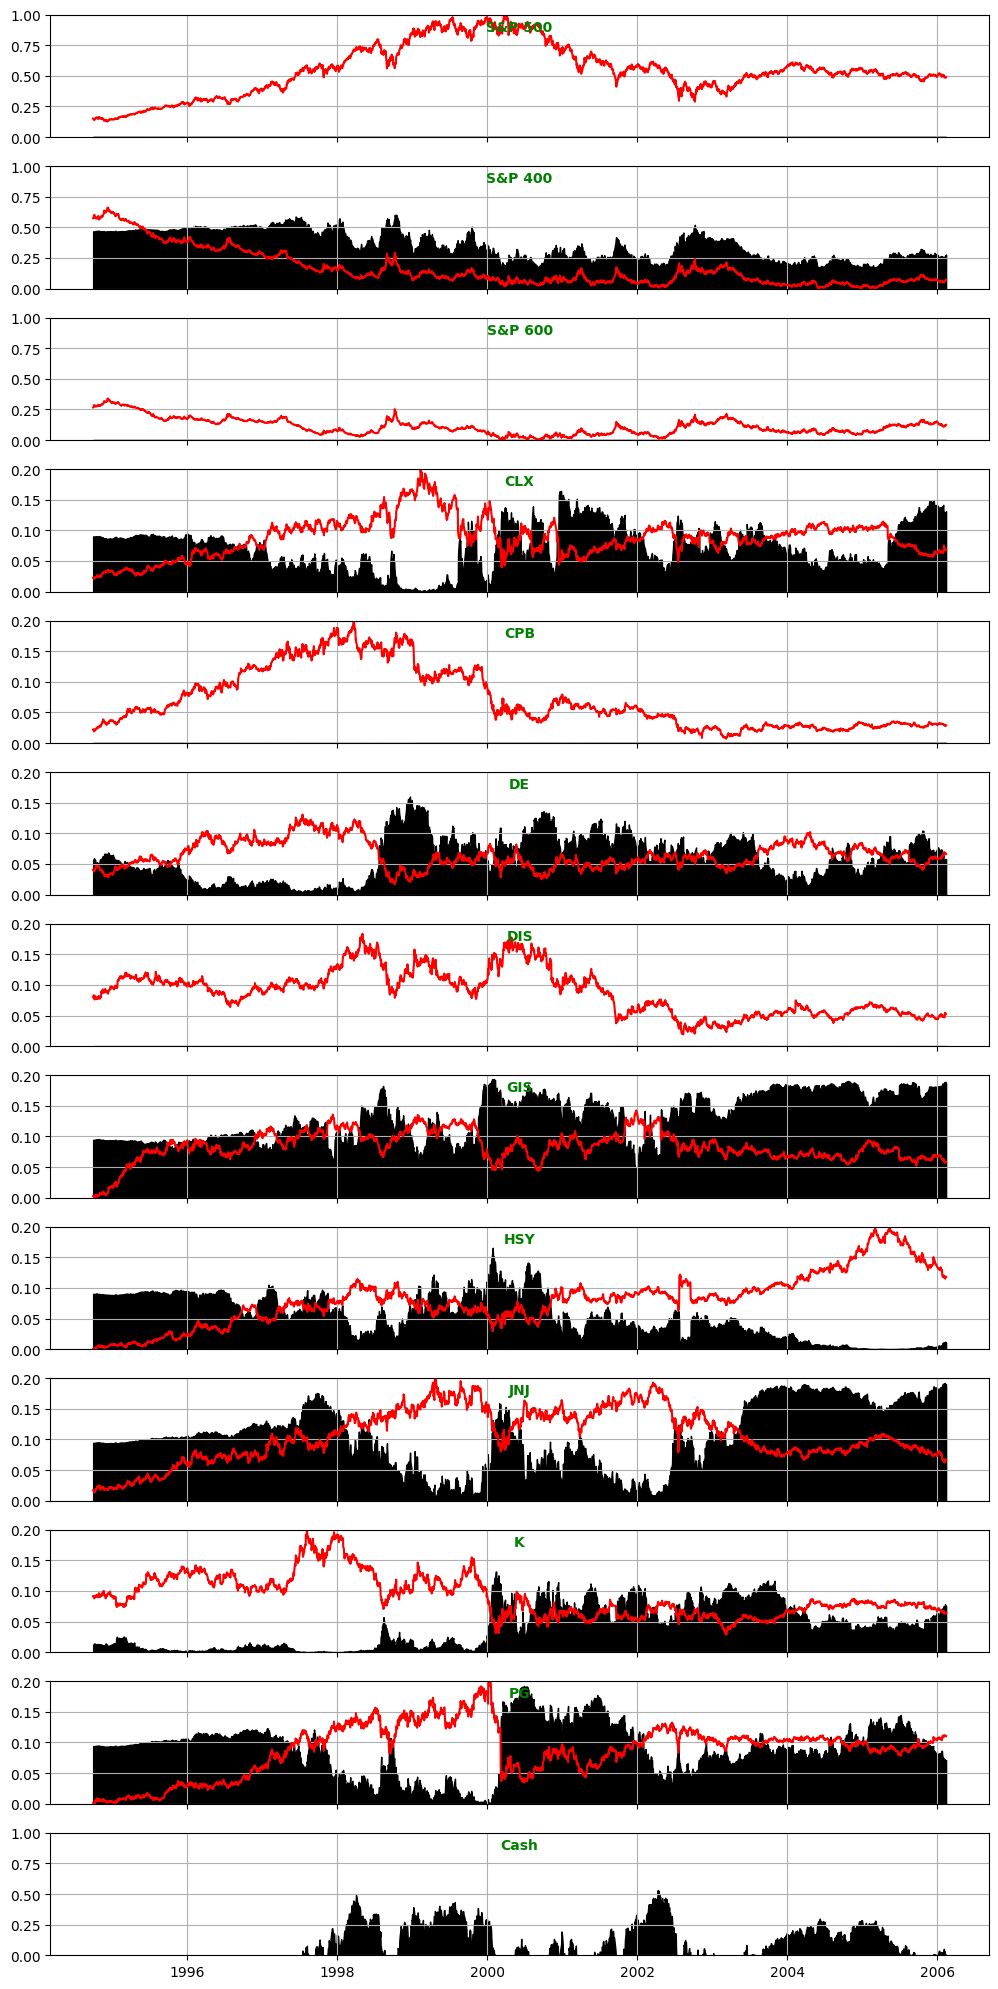

In [ ]:
plot_weights_signals(idx=idx_train)

We now show the stock-weights and signals for the test-set. This is "out-of-sample" data that has not been seen during optimization of the portfolio model. We see that the portfolio model still scales the stock-weights according to their signals, so it seems to do what we expect.

Note that the weights will most likely change every time you run this, because we are using a stochastic heuristic optimizer to find the parameters for the portfolio model.

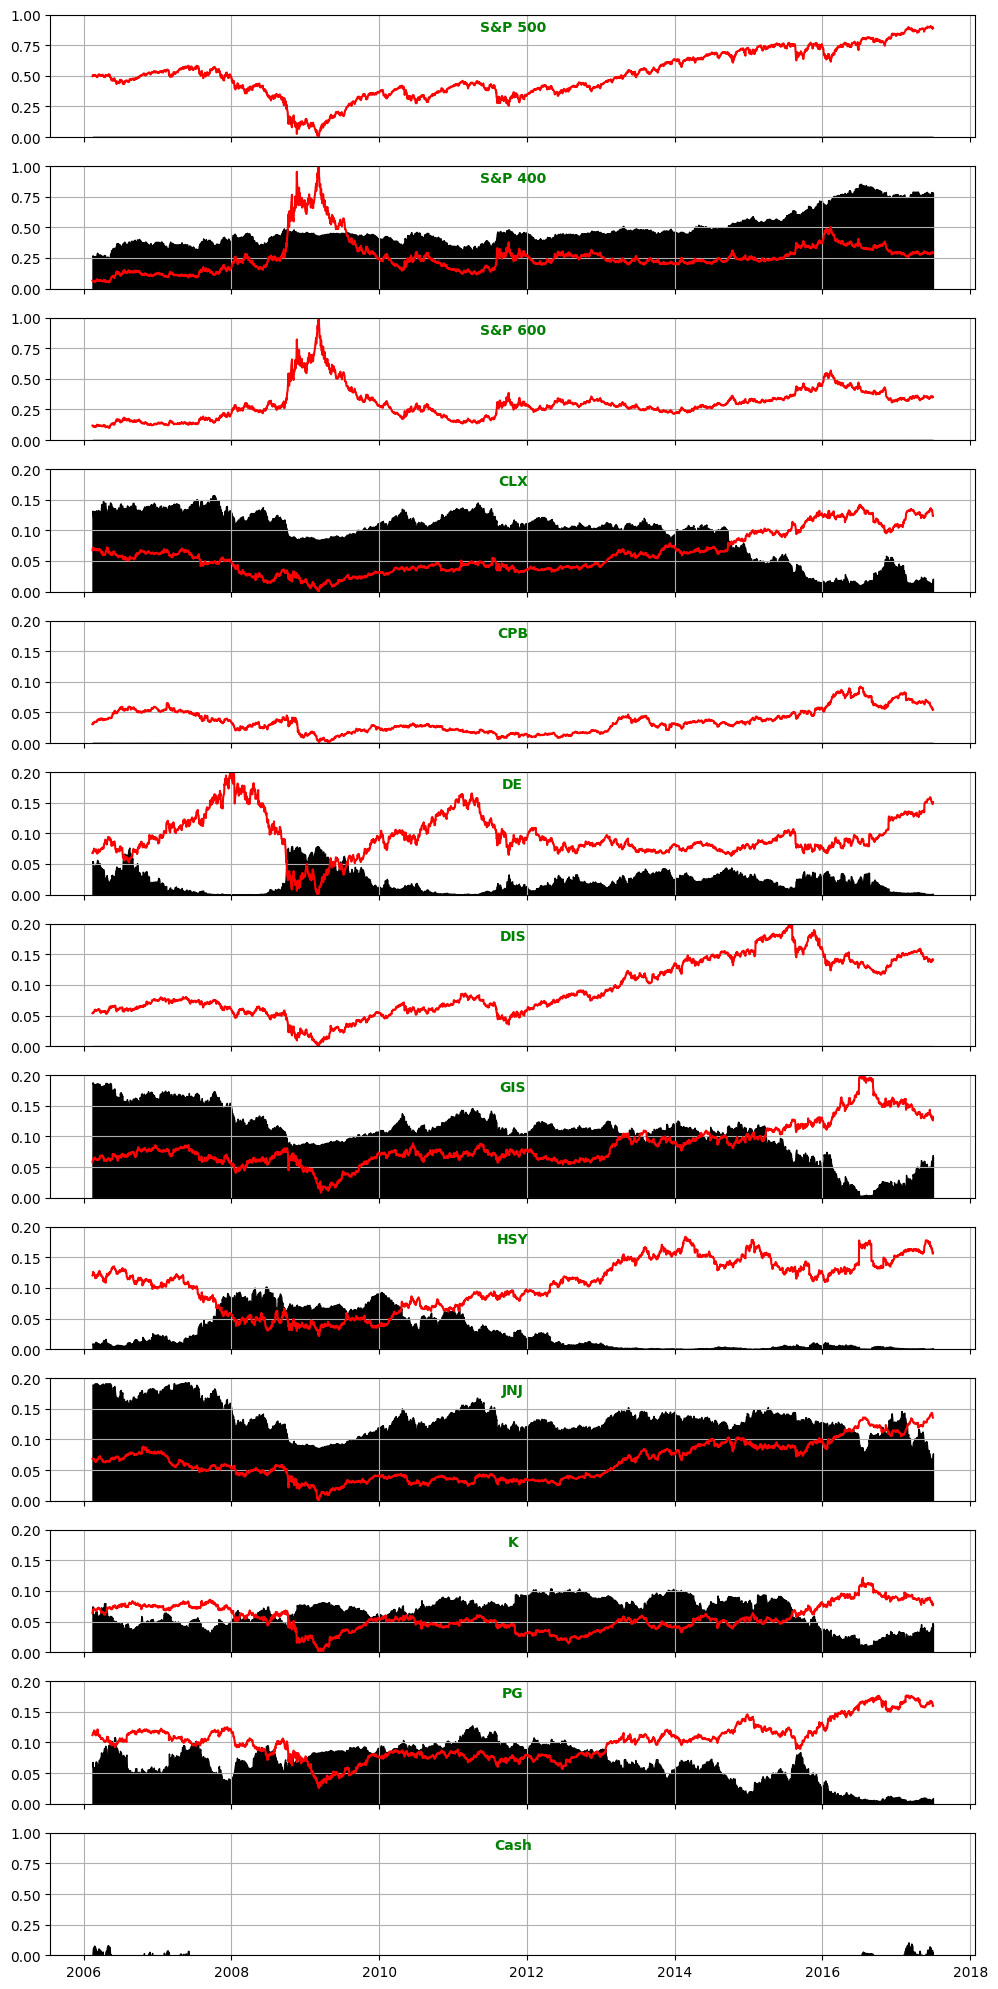

In [ ]:
plot_weights_signals(idx=idx_test)

## Compare Returns

In [ ]:
def plot_comparison(title, idx, tickers, dfs):
    """
    Plot comparison of Total Return for the given tickers
    and the different portfolios: Equal, fixed and adaptive.

    :param title: Title of the plot.
    :param idx: List of integer indices into dates, signals, etc.
    :param tickers: List of strings for the tickers.
    :param dfs: List of DataFrames corresponding to the tickers.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Get the data for the period given by the indices.
    dates_idx = dates[idx]
    daily_rets_idx = daily_rets[idx]
    signals_idx = signals_scaled[idx, :]

    # Plot the Total Return for the given stocks.
    for ticker, df in zip(tickers, dfs):
        # Get the Total Return for the given period.
        tot_ret = df[TOTAL_RETURN][dates_idx].dropna()

        # Normalize to begin at 1.0
        tot_ret /= tot_ret[0]

        # Plot it.
        ax.plot(tot_ret, label=ticker)

    # Plot portfolio value using equal weights.
    value = portfolio_equal.value(daily_rets=daily_rets_idx)
    ax.plot(dates_idx, value, label="Equal Weights")

    # Plot portfolio value using fixed weights.
    value = portfolio_fixed.value(daily_rets=daily_rets_idx)
    ax.plot(dates_idx, value, label="Fixed Weights")

    # Plot portfolio value using adaptive weights.
    value = portfolio_adapt.value(daily_rets=daily_rets_idx,
                                  signals=signals_idx)
    ax.plot(dates_idx, value, label="Adapt Weights")

    # Set the axis-labels.
    ax.set_ylabel("Total Return")

    # Add legend to plot.
    ax.legend(loc=0)

    # Add grid to plot.
    ax.grid()

    # Set the plot's title.
    ax.set_title(title)

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now plot a comparison of the different portfolio models to the stock indices. First we show it for the training-set, so this is the period of data used during optimization of the portfolio models. We see that the equal-weight portfolio performed better than all three stock indices. The fixed-weight portfolio performed even better, and the adaptive-weight portfolio performed best of all.

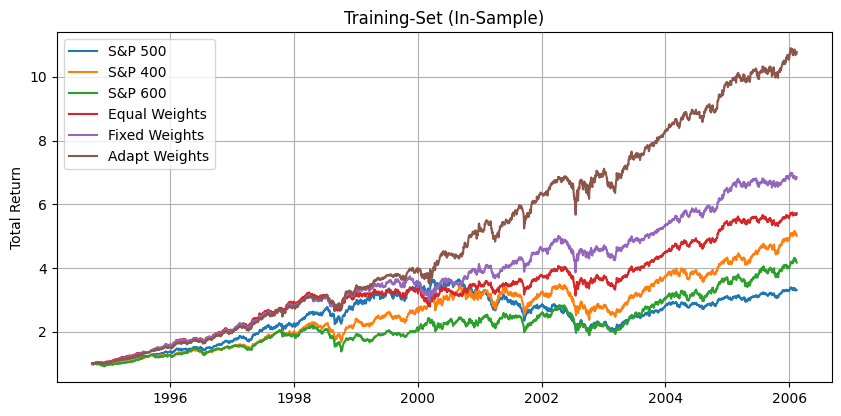

In [ ]:
plot_comparison(title="Training-Set (In-Sample)", idx=idx_train,
                tickers=[ticker_SP500, ticker_SP400, ticker_SP600],
                dfs=[df_SP500, df_SP400, df_SP600])

Let us now show the same comparison but for the test-set. This is out-of-sample data that was not seen during training of the portfolio models. The results change slightly each time you run this, because the optimization is heuristic and stochastic. But in general, the adaptive-weight portfolio performs slightly better than the fixed-weight and equal-weight portfolios. But the difference is probably too small to conclude the adaptive-weight portfolio is better, especially when taking trading costs and taxes into consideration, as discussed below.

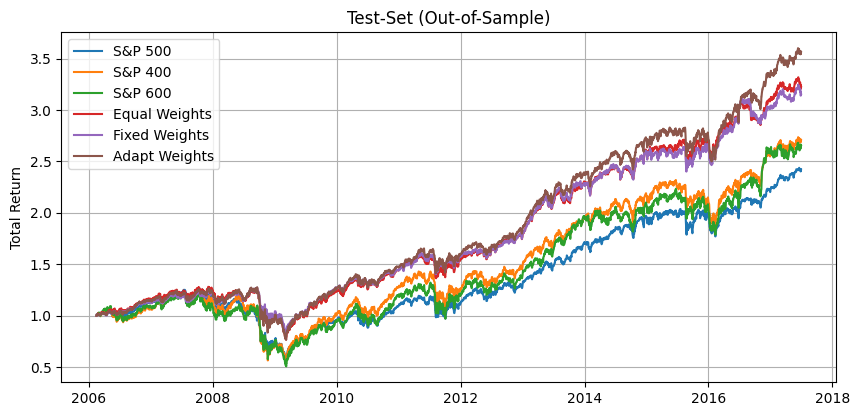

In [ ]:
plot_comparison(title="Test-Set (Out-of-Sample)", idx=idx_test,
                tickers=[ticker_SP500, ticker_SP400, ticker_SP600],
                dfs=[df_SP500, df_SP400, df_SP600])

## Discussion

A method was presented for optimizing investment portfolios using predictive signals, which significantly outperformed the equal-weight and fixed-weight portfolios, as well as the stock indices on the training-set. However, there was only a slight advantage on the test-set with out-of-sample data.

When taking trading costs and taxes into consideration, it is quite likely that the adaptive-weight portfolio would perform significantly worse than all of these stock indices.

However, the method did seem to allocate the portfolio-weights as we would expect by having large weights for cheap stocks and vice versa.

The reason it did not work better on the test-set, is perhaps that we were using predictive signals such as the P/Sales ratio which are mostly useful for longer investment periods of e.g. 10 years. We also considered a very small number of stocks. The combination of these two issues means that it is easy for the portfolio model to overfit on the training-data.

If we instead had 100 stocks and limited their weights to e.g. 5% or less of the portfolio, then the diversification would probably help get better portfolio returns on the test-set. It would probably also help to use more predictive signals, especially for short- and mid-term investment periods. But short-term signals are probably fairly weak predictors, which again means that we need more stocks for diversification.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results.

Here are some ideas you could start researching:

- Try another `max_weight` for the stocks and indices.

- Try another split between the training- and test-sets. Does it change the performance on the test-set? Why?

- Try modifying the fitness function.

- The portfolio models are optimized using a heuristic and stochastic method, so they may give different results each time they are optimized. Make an ensemble of portfolio models simply by creating multiple object instances and average the weights they produce. How does that affect the portfolio weights?

- Use many more stocks for the portfolio. It is important that you first test whether the signals predict the future returns as we did in the [first paper in this series](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb).

- Try and find more signals that are good predictors of future returns.

- When you have a portfolio model that performs well on the test-set, use the more detailed analysis from the [second paper in this series](https://github.com/Hvass-Labs/FinanceOps/blob/master/02_Comparing_Stock_Indices.ipynb) to properly compare the returns of your portfolio model to the stock indices.

- If your portfolio model performs well, then take trading-costs and taxes into account. Does your portfolio model still perform well?

- The optimization may get stuck in local optima. To avoid this try and train the portfolio model for one stock at a time and then finalize it by training a final scaler. So instead of having the usual formula: $Weight = Sigmoid( a \cdot Signal + b )$ where we train the parameters $a$ and $b$ for all stocks simultaneously, we now have the formula: $Weight = Sigmoid( a \cdot Signal + b ) \cdot c$ where the parameters $a$ and $b$ are first trained for each stock individually, and then $c$ is trained jointly for all stocks simultaneously.

- Try and make more advanced mathematical functions in the portfolio models, maybe even using neural networks. Be careful with overfitting and make sure that signals are only used to produce weights for stocks where there is a causal relationship.

- Allow both long-investing and short-selling. What are the risks of doing this?

- Use overnight interest rates instead of the cash-portion of the portfolio.

## License (MIT)

Copyright (c) 2015-18 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.